### Original Social Network Graph at T=0

In [842]:
import random
import networkx as nx
import pandas as pd
compartments = ['S', 'E', 'I', 'R', 'M', 'Z']

def create_graph(N):
    G = nx.Graph()
    for i in range(N):
        G.add_node(i)

    # assign at least one node to each compartment
    compartment_nodes = {}
    for compartment in compartments:
        node = random.choice(list(G.nodes()))
        compartment_nodes[compartment] = node
        G.nodes[node]['compartment'] = compartment

    # assign remaining nodes to compartments randomly
    for node in G.nodes():
        if 'compartment' not in G.nodes[node]:
            compartment = random.choice(list(compartments))
            G.nodes[node]['compartment'] = compartment

    # add edges randomly between nodes
    for i in range(N):
        for j in range(i+1, N):
            if random.random() < 0.3:
                G.add_edge(i, j)

    # calculate edge weights using jaccard similarity index
    for u, v in G.edges():
        compartment1 = G.nodes[u]['compartment']
        compartment2 = G.nodes[v]['compartment']
        if compartment1 == compartment2:
            weight = 0.0
        else:
            neighbors1 = set(G.neighbors(u))
            neighbors2 = set(G.neighbors(v))
            weight = len(neighbors1.intersection(neighbors2)) / len(neighbors1.union(neighbors2))
        G[u][v]['weight'] = weight
    
    return G

In [843]:
import matplotlib.pyplot as plt

def plot_graph(G):
    # Assign different colors to nodes based on their compartments
    node_colors = []
    for node in G.nodes:
        compartment = G.nodes[node]['compartment']
        if compartment == 'S':
            node_colors.append('blue')
        elif compartment == 'E':
            node_colors.append('green')
        elif compartment == 'I':
            node_colors.append('red')
        elif compartment == 'R':
            node_colors.append('orange')
        elif compartment == 'M':
            node_colors.append('purple')
        elif compartment == 'Z':
            node_colors.append('brown')
    
    # Plot the graph in shell layout
    pos = nx.shell_layout(G)
    nx.draw(G, pos=pos, node_color=node_colors, with_labels=True)
    plt.show()

In [844]:
def edge_weights_show(G):
    # print edge list with weights
    for u, v, w in G.edges(data=True):
        print(f"{u} -- {v} : {w['weight']}")

In [845]:
from tabulate import tabulate

def adjacency_mat_plot(G):
    adj_mat = nx.to_numpy_matrix(G)
    df = pd.DataFrame(adj_mat, index=G.nodes(), columns=G.nodes())
    print("Adjacency Matrix:\n")
    print(tabulate(df, headers='keys', tablefmt='fancy_grid'))

def compartment_info_tab(G):
    compartment_info = {}
    for node in G.nodes():
        compartment = G.nodes[node]['compartment']
        if compartment not in compartment_info:
            compartment_info[compartment] = []
        compartment_info[compartment].append(node)

    compartment_lengths = [len(v) for v in compartment_info.values()]
    max_compartment_length = max(compartment_lengths)

    for compartment in compartment_info:
        while len(compartment_info[compartment]) < max_compartment_length:
            compartment_info[compartment].append('')
            
    df = pd.DataFrame(compartment_info)
    df.index.name = 'Compartment'
    print("\nCompartment Info:\n")
    print(tabulate(df, headers='keys', tablefmt='fancy_grid', showindex=False))

In [846]:
def deriv_seirmz(y, t, N, alpha, beta, gamma, delta, a, c, d, f, g, b, c1, c2, c3, c4, c5, c6, epsilon):
    S, E, I, R, M, Z = y
    dSdt = -(alpha * S * E) - (alpha * I * S) + ((c1 - c2) * epsilon)
    dEdt = (alpha * S * E) + (alpha * I * S) - (a * E) - (b * delta * E) - (c * E) - (c3 * epsilon)
    dIdt = (a * E - beta * I) - (b * gamma * I) - (d * I) + (f * Z)  - (c4 * epsilon)
    dRdt = (beta * I) + (g * Z) - (c5 * epsilon)
    dMdt = (delta * b * E) + (gamma * b * I)
    dZdt = (c * E) + (d * I) - (f * Z) - (g * Z) - (c6 * epsilon)
    return dSdt, dEdt, dIdt, dRdt, dMdt, dZdt

In [847]:
from collections import Counter
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from constants import alpha, beta, gamma, delta, a, c, d, f, g, c1, c2, c3, c4, c5, c6, b, epsilon

def seirmz_sim(G):
    # Create a list of compartment labels for all nodes in the graph
    compartment_labels = [G.nodes[node]['compartment'] for node in G.nodes()]

    # Count the number of nodes in each compartment
    node_counts = Counter(compartment_labels)

    # Print the node counts for each compartment
    for compartment in compartments:
        count = node_counts[compartment]
        print(f"Number of nodes in compartment {compartment}: {count}")
    S0 = node_counts['S']
    E0 = node_counts['E']
    I0 = node_counts['I']
    R0 = node_counts['R']
    M0 = node_counts['M']
    Z0 = node_counts['Z']
    # A grid of time points (in days)
    t = np.linspace(0, 160, 160)
    # Initial conditions vector
    y0 = S0, E0, I0, R0, M0, Z0
    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv_seirmz, y0, t, args=(N, alpha, beta, gamma, delta, a, c, d, f, g, b, c1, c2, c3, c4, c5, c6, epsilon))
    S, E, I, R, M, Z = ret.T

    # Plot the data on four separate curves for S(t), I(t), R(t) and M(t)
    fig, ax = plt.subplots(figsize=(10, 5))
    fig.patch.set_facecolor('white')
    ax.set_facecolor('#dddddd')
    ax.plot(t, S, 'b', alpha=0.5, lw=2, label='Susceptible')
    ax.plot(t, E, 'c', alpha=0.5, lw=2, label='Exposed')
    ax.plot(t, I, 'r', alpha=0.5, lw=2, label='Infected')
    ax.plot(t, R, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
    ax.plot(t, M, 'y', alpha=0.5, lw=2, label='Mortality')
    ax.plot(t, Z, 'k', alpha=0.5, lw=2, label='Skeptic')
    ax.set_xlabel('Time /days')
    ax.set_ylabel('Population')
    ax.set_ylim(0,N)
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.show()

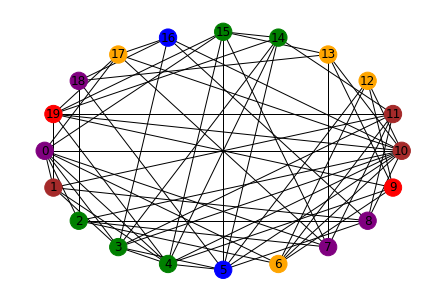

In [848]:
N = 20
G = create_graph(N)
plot_graph(G)

In [849]:
compartment_info_tab(G)


Compartment Info:

╒═════╤═════╤═════╤═════╤═════╤═════╕
│ M   │ Z   │   E │ S   │ R   │ I   │
╞═════╪═════╪═════╪═════╪═════╪═════╡
│ 0   │ 1   │   2 │ 5   │ 6   │ 9   │
├─────┼─────┼─────┼─────┼─────┼─────┤
│ 7   │ 10  │   3 │ 16  │ 12  │ 19  │
├─────┼─────┼─────┼─────┼─────┼─────┤
│ 8   │ 11  │   4 │     │ 13  │     │
├─────┼─────┼─────┼─────┼─────┼─────┤
│ 18  │     │  14 │     │ 17  │     │
├─────┼─────┼─────┼─────┼─────┼─────┤
│     │     │  15 │     │     │     │
╘═════╧═════╧═════╧═════╧═════╧═════╛


In [850]:
edge_weights_show(G)

0 -- 1 : 0.15384615384615385
0 -- 2 : 0.25
0 -- 3 : 0.21428571428571427
0 -- 4 : 0.2857142857142857
0 -- 6 : 0.15384615384615385
0 -- 7 : 0.0
0 -- 10 : 0.3125
0 -- 15 : 0.14285714285714285
0 -- 17 : 0.16666666666666666
1 -- 3 : 0.2727272727272727
1 -- 4 : 0.25
1 -- 8 : 0.09090909090909091
1 -- 11 : 0.0
1 -- 19 : 0.16666666666666666
2 -- 6 : 0.2
2 -- 7 : 0.09090909090909091
2 -- 8 : 0.09090909090909091
2 -- 10 : 0.2
2 -- 18 : 0.0
3 -- 4 : 0.0
3 -- 5 : 0.23076923076923078
3 -- 10 : 0.25
3 -- 11 : 0.15384615384615385
3 -- 14 : 0.0
3 -- 16 : 0.08333333333333333
4 -- 5 : 0.3076923076923077
4 -- 9 : 0.07692307692307693
4 -- 10 : 0.23529411764705882
4 -- 14 : 0.0
4 -- 15 : 0.0
4 -- 19 : 0.4166666666666667
5 -- 8 : 0.07692307692307693
5 -- 10 : 0.25
5 -- 12 : 0.09090909090909091
5 -- 14 : 0.2727272727272727
5 -- 15 : 0.15384615384615385
5 -- 18 : 0.0
6 -- 9 : 0.1
6 -- 10 : 0.2
6 -- 11 : 0.0
6 -- 12 : 0.0
7 -- 11 : 0.0
7 -- 13 : 0.1
7 -- 15 : 0.18181818181818182
7 -- 17 : 0.1
8 -- 10 : 0.2
8 --

In [851]:
adjacency_mat_plot(G)

Adjacency Matrix:

╒════╤══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤══════════╤═══════════╤═══════════╤═══════════╤══════════╤═══════════╤═══════════╤═══════════╤══════════╤═══════════╤═══════════╤═══════════╤══════╤═══════════╕
│    │        0 │         1 │         2 │         3 │         4 │         5 │        6 │         7 │         8 │         9 │       10 │        11 │        12 │        13 │       14 │        15 │        16 │        17 │   18 │        19 │
╞════╪══════════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╪══════════╪═══════════╪═══════════╪═══════════╪══════════╪═══════════╪═══════════╪═══════════╪══════════╪═══════════╪═══════════╪═══════════╪══════╪═══════════╡
│  0 │ 0        │ 0.153846  │ 0.25      │ 0.214286  │ 0.285714  │ 0         │ 0.153846 │ 0         │ 0         │ 0         │ 0.3125   │ 0         │ 0         │ 0         │ 0        │ 0.142857  │ 0         │ 0.166667  │    0 │ 0         │
├────┼──────────┼───────────┼

Number of nodes in compartment S: 2
Number of nodes in compartment E: 5
Number of nodes in compartment I: 2
Number of nodes in compartment R: 4
Number of nodes in compartment M: 4
Number of nodes in compartment Z: 3


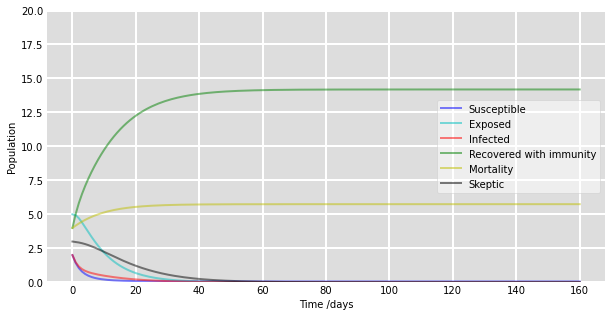

In [852]:
seirmz_sim(G)

### Adding skeptic nodes randomly

In [853]:
import random
def add_skeptic_nodes(G, n):
    new_nodes = range(len(G.nodes()), len(G.nodes())+n)
    for i in new_nodes:
        G.add_node(i, compartment='Z')
        for j in range(len(G.nodes())):
            if j != i and random.random() < 0.3:
                G.add_edge(i, j)
    
    # calculate edge weights using jaccard similarity index
    for u, v in G.edges():
        compartment1 = G.nodes[u]['compartment']
        compartment2 = G.nodes[v]['compartment']
        if compartment1 == compartment2:
            weight = 0.0
        else:
            neighbors1 = set(G.neighbors(u))
            neighbors2 = set(G.neighbors(v))
            weight = len(neighbors1.intersection(neighbors2)) / len(neighbors1.union(neighbors2))
        G[u][v]['weight'] = weight
    return G


In [854]:
newG = add_skeptic_nodes(G,5)

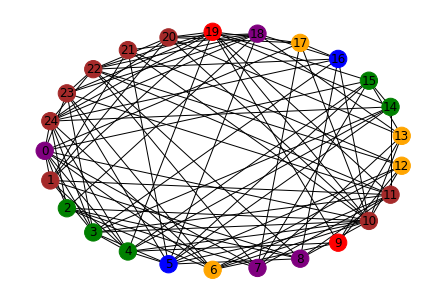

In [855]:
plot_graph(newG)

In [856]:
import importlib
import constants
importlib.reload(constants)

def calculate_updated_f(G):
    total_weight = 0
    num_edges = 0
    for u, v in G.edges():
        if G.nodes[u]['compartment'] == 'Z' and G.nodes[v]['compartment'] == 'I' or \
            G.nodes[u]['compartment'] == 'I' and G.nodes[v]['compartment'] == 'Z':
            total_weight += G[u][v]['weight']
            num_edges += 1
    if num_edges == 0:
        return 0
    else:
        return total_weight / num_edges

In [857]:
f_new = f * calculate_updated_f(newG)
d_new = d/calculate_updated_f(newG)
print(f_new)
print(d_new)

0.010138517649622779
0.04931687424922552


In [858]:
def calculate_updated_g(G):
    total_weight = 0
    num_edges = 0
    for u, v in G.edges():
        if G.nodes[u]['compartment'] == 'Z' and G.nodes[v]['compartment'] == 'R' or \
            G.nodes[u]['compartment'] == 'R' and G.nodes[v]['compartment'] == 'Z':
            total_weight += G[u][v]['weight']
            num_edges += 1
    if num_edges == 0:
        return 0
    else:
        return total_weight / num_edges

g_new = g * calculate_updated_g(newG)
print(g_new)

0.006888893914822708


In [859]:
compartment_info_tab(newG)


Compartment Info:

╒═════╤═════╤═════╤═════╤═════╤═════╕
│ M   │   Z │ E   │ S   │ R   │ I   │
╞═════╪═════╪═════╪═════╪═════╪═════╡
│ 0   │   1 │ 2   │ 5   │ 6   │ 9   │
├─────┼─────┼─────┼─────┼─────┼─────┤
│ 7   │  10 │ 3   │ 16  │ 12  │ 19  │
├─────┼─────┼─────┼─────┼─────┼─────┤
│ 8   │  11 │ 4   │     │ 13  │     │
├─────┼─────┼─────┼─────┼─────┼─────┤
│ 18  │  20 │ 14  │     │ 17  │     │
├─────┼─────┼─────┼─────┼─────┼─────┤
│     │  21 │ 15  │     │     │     │
├─────┼─────┼─────┼─────┼─────┼─────┤
│     │  22 │     │     │     │     │
├─────┼─────┼─────┼─────┼─────┼─────┤
│     │  23 │     │     │     │     │
├─────┼─────┼─────┼─────┼─────┼─────┤
│     │  24 │     │     │     │     │
╘═════╧═════╧═════╧═════╧═════╧═════╛


In [860]:

def new_seirmz_sim(G):
    # Create a list of compartment labels for all nodes in the graph
    compartment_labels = [G.nodes[node]['compartment'] for node in G.nodes()]

    # Count the number of nodes in each compartment
    node_counts = Counter(compartment_labels)

    # Print the node counts for each compartment
    for compartment in compartments:
        count = node_counts[compartment]
        print(f"Number of nodes in compartment {compartment}: {count}")
    S0 = node_counts['S']
    E0 = node_counts['E']
    I0 = node_counts['I']
    R0 = node_counts['R']
    M0 = node_counts['M']
    Z0 = node_counts['Z']
    # A grid of time points (in days)
    t = np.linspace(0, 160, 160)
    # Initial conditions vector
    y0 = S0, E0, I0, R0, M0, Z0
    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv_seirmz, y0, t, args=(N, alpha, beta, gamma, delta, a, c, d_new, f_new, g_new, b, c1, c2, c3, c4, c5, c6, epsilon))
    S, E, I, R, M, Z = ret.T

    # Plot the data on four separate curves for S(t), I(t), R(t) and M(t)
    fig, ax = plt.subplots(figsize=(10, 5))
    fig.patch.set_facecolor('white')
    ax.set_facecolor('#dddddd')
    ax.plot(t, S, 'b', alpha=0.5, lw=2, label='Susceptible')
    ax.plot(t, E, 'c', alpha=0.5, lw=2, label='Exposed')
    ax.plot(t, I, 'r', alpha=0.5, lw=2, label='Infected')
    ax.plot(t, R, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
    ax.plot(t, M, 'y', alpha=0.5, lw=2, label='Mortality')
    ax.plot(t, Z, 'k', alpha=0.5, lw=2, label='Skeptic')
    ax.set_xlabel('Time /days')
    ax.set_ylabel('Population')
    ax.set_ylim(0,N)
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.show()

Number of nodes in compartment S: 2
Number of nodes in compartment E: 5
Number of nodes in compartment I: 2
Number of nodes in compartment R: 4
Number of nodes in compartment M: 4
Number of nodes in compartment Z: 8


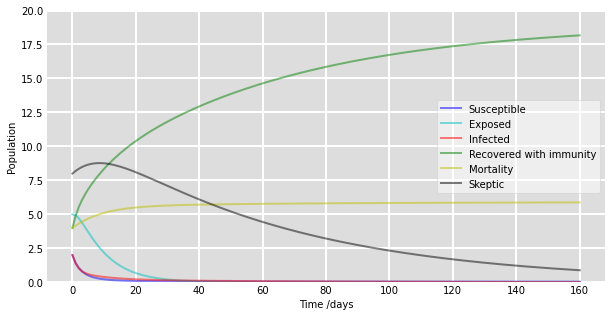

In [861]:
new_seirmz_sim(newG)

### Adding skeptic nodes as maximum degree nodes

In [862]:
def add_skeptic_nodes(G, n):
    """
    Add n skeptic nodes to Graph G, and connect them to all other nodes in a way that the new nodes have the highest degree.
    """
    z_nodes = [node for node, data in G.nodes(data=True) if data['compartment'] == 'Z']
    for i in range(n):
        # Add the new node to the graph with a 'Z' compartment label
        G.add_node(len(G), compartment='Z')
        # Connect the new node to all other nodes
        for node in z_nodes:
            G.add_edge(node, len(G)-1)
        z_nodes.append(len(G)-1)
    for u, v in G.edges():
        compartment1 = G.nodes[u]['compartment']
        compartment2 = G.nodes[v]['compartment']
        if compartment1 == compartment2:
            weight = 0.0
        else:
            neighbors1 = set(G.neighbors(u))
            neighbors2 = set(G.neighbors(v))
            weight = len(neighbors1.intersection(neighbors2)) / len(neighbors1.union(neighbors2))
        G[u][v]['weight'] = weight
    return G

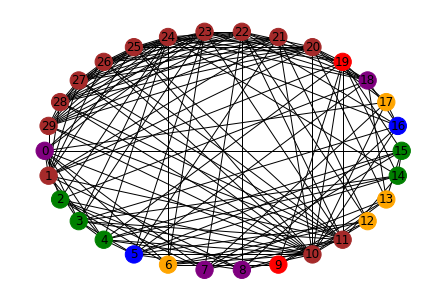

In [863]:
newmaxdegreeG = add_skeptic_nodes(G,5)
plot_graph(newmaxdegreeG)

In [864]:
max_degree_node, max_degree = max(newmaxdegreeG.degree(), key=lambda x: x[1])
compartment = newmaxdegreeG.nodes[max_degree_node]['compartment']
print(f"The node with maximum degree is {max_degree_node} with degree {max_degree}, and it belongs to compartment {compartment}.")

The node with maximum degree is 10 with degree 19, and it belongs to compartment Z.


In [865]:
import importlib
import constants
importlib.reload(constants)

def calculate_updated_f(G):
    total_weight = 0
    num_edges = 0
    for u, v in G.edges():
        if G.nodes[u]['compartment'] == 'Z' and G.nodes[v]['compartment'] == 'I' or \
            G.nodes[u]['compartment'] == 'I' and G.nodes[v]['compartment'] == 'Z':
            total_weight += G[u][v]['weight']
            num_edges += 1
    if num_edges == 0:
        return 0
    else:
        return total_weight / num_edges

In [866]:
f_new = f * calculate_updated_f(newmaxdegreeG)
d_new = d/calculate_updated_f(newmaxdegreeG)
print(f_new)
print(d_new)

0.00787757790863381
0.0634712859458998


In [867]:
def calculate_updated_g(G):
    total_weight = 0
    num_edges = 0
    for u, v in G.edges():
        if G.nodes[u]['compartment'] == 'Z' and G.nodes[v]['compartment'] == 'R' or \
            G.nodes[u]['compartment'] == 'R' and G.nodes[v]['compartment'] == 'Z':
            total_weight += G[u][v]['weight']
            num_edges += 1
    if num_edges == 0:
        return 0
    else:
        return total_weight / num_edges

g_new = g * calculate_updated_g(newmaxdegreeG)
print(g_new)

0.00507022295651623


Number of nodes in compartment S: 2
Number of nodes in compartment E: 5
Number of nodes in compartment I: 2
Number of nodes in compartment R: 4
Number of nodes in compartment M: 4
Number of nodes in compartment Z: 13


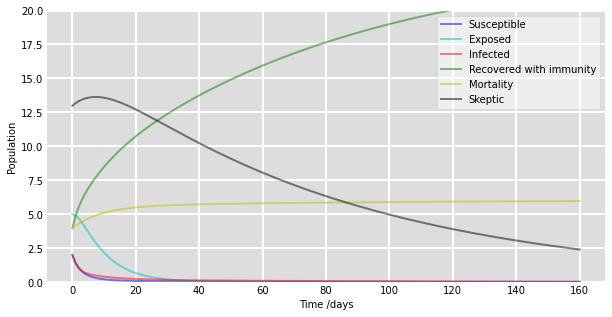

In [868]:
def new_seirmz_sim(G):
    # Create a list of compartment labels for all nodes in the graph
    compartment_labels = [G.nodes[node]['compartment'] for node in G.nodes()]

    # Count the number of nodes in each compartment
    node_counts = Counter(compartment_labels)

    # Print the node counts for each compartment
    for compartment in compartments:
        count = node_counts[compartment]
        print(f"Number of nodes in compartment {compartment}: {count}")
    S0 = node_counts['S']
    E0 = node_counts['E']
    I0 = node_counts['I']
    R0 = node_counts['R']
    M0 = node_counts['M']
    Z0 = node_counts['Z']
    # A grid of time points (in days)
    t = np.linspace(0, 160, 160)
    # Initial conditions vector
    y0 = S0, E0, I0, R0, M0, Z0
    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv_seirmz, y0, t, args=(N, alpha, beta, gamma, delta, a, c, d_new, f_new, g_new, b, c1, c2, c3, c4, c5, c6, epsilon))
    S, E, I, R, M, Z = ret.T

    # Plot the data on four separate curves for S(t), I(t), R(t) and M(t)
    fig, ax = plt.subplots(figsize=(10, 5))
    fig.patch.set_facecolor('white')
    ax.set_facecolor('#dddddd')
    ax.plot(t, S, 'b', alpha=0.5, lw=2, label='Susceptible')
    ax.plot(t, E, 'c', alpha=0.5, lw=2, label='Exposed')
    ax.plot(t, I, 'r', alpha=0.5, lw=2, label='Infected')
    ax.plot(t, R, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
    ax.plot(t, M, 'y', alpha=0.5, lw=2, label='Mortality')
    ax.plot(t, Z, 'k', alpha=0.5, lw=2, label='Skeptic')
    ax.set_xlabel('Time /days')
    ax.set_ylabel('Population')
    ax.set_ylim(0,N)
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.show()

new_seirmz_sim(newmaxdegreeG)

### Adding Skeptic Nodes as Maximum Centrality nodes

In [869]:

def add_nodes_with_highest_betweenness(G, n):
    # Add n nodes to the Z compartment
    z_nodes = []
    for i in range(n):
        node_id = G.number_of_nodes()
        G.add_node(node_id, compartment='Z')
        z_nodes.append(node_id)

    # Calculate betweenness centrality
    betweenness = nx.betweenness_centrality(G)

    # Connect new nodes to other nodes based on highest betweenness
    for z_node in z_nodes:
        max_betweenness = -1
        max_node = None
        for node in G.nodes():
            if G.nodes[node]['compartment'] != 'Z':
                if betweenness[node] > max_betweenness:
                    max_betweenness = betweenness[node]
                    max_node = node
        G.add_edge(z_node, max_node)
    for u, v in G.edges():
        compartment1 = G.nodes[u]['compartment']
        compartment2 = G.nodes[v]['compartment']
        if compartment1 == compartment2:
            weight = 0.0
        else:
            neighbors1 = set(G.neighbors(u))
            neighbors2 = set(G.neighbors(v))
            weight = len(neighbors1.intersection(neighbors2)) / len(neighbors1.union(neighbors2))
        G[u][v]['weight'] = weight
    return G

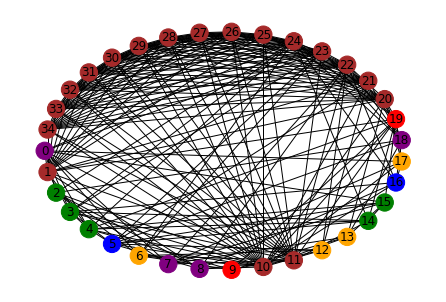

In [870]:
nbG = add_skeptic_nodes(G,5)
plot_graph(nbG)

In [871]:
betweenness_centrality = nx.betweenness_centrality(nbG)
max_betweenness_node = max(betweenness_centrality, key=betweenness_centrality.get)
compartment = nbG.nodes[max_betweenness_node]['compartment']
print(f"The node with maximum betweenness centrality is {max_betweenness_node} with centrality {betweenness_centrality[max_betweenness_node]}, and it belongs to compartment {compartment}.")

The node with maximum betweenness centrality is 10 with centrality 0.12891667234695212, and it belongs to compartment Z.


In [872]:
import importlib
import constants
importlib.reload(constants)

def calculate_updated_f(G):
    total_weight = 0
    num_edges = 0
    for u, v in G.edges():
        if G.nodes[u]['compartment'] == 'Z' and G.nodes[v]['compartment'] == 'I' or \
            G.nodes[u]['compartment'] == 'I' and G.nodes[v]['compartment'] == 'Z':
            total_weight += G[u][v]['weight']
            num_edges += 1
    if num_edges == 0:
        return 0
    else:
        return total_weight / num_edges

f_new = f * calculate_updated_f(nbG)
d_new = d/calculate_updated_f(nbG)
print(f_new)
print(d_new)

0.006445607849548736
0.07757220291256248


In [873]:
def calculate_updated_g(G):
    total_weight = 0
    num_edges = 0
    for u, v in G.edges():
        if G.nodes[u]['compartment'] == 'Z' and G.nodes[v]['compartment'] == 'R' or \
            G.nodes[u]['compartment'] == 'R' and G.nodes[v]['compartment'] == 'Z':
            total_weight += G[u][v]['weight']
            num_edges += 1
    if num_edges == 0:
        return 0
    else:
        return total_weight / num_edges

g_new = g * calculate_updated_g(nbG)
print(g_new)

0.004026539022826765


Number of nodes in compartment S: 2
Number of nodes in compartment E: 5
Number of nodes in compartment I: 2
Number of nodes in compartment R: 4
Number of nodes in compartment M: 4
Number of nodes in compartment Z: 18


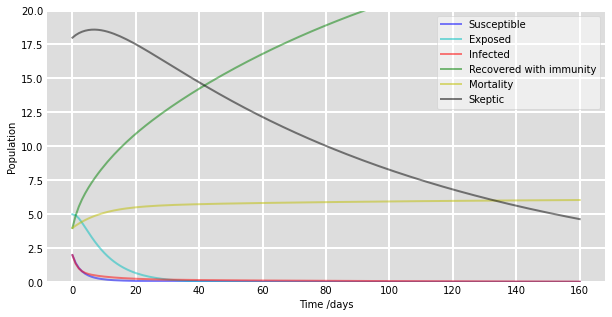

In [874]:
def new_seirmz_sim(G):
    # Create a list of compartment labels for all nodes in the graph
    compartment_labels = [G.nodes[node]['compartment'] for node in G.nodes()]

    # Count the number of nodes in each compartment
    node_counts = Counter(compartment_labels)

    # Print the node counts for each compartment
    for compartment in compartments:
        count = node_counts[compartment]
        print(f"Number of nodes in compartment {compartment}: {count}")
    S0 = node_counts['S']
    E0 = node_counts['E']
    I0 = node_counts['I']
    R0 = node_counts['R']
    M0 = node_counts['M']
    Z0 = node_counts['Z']
    # A grid of time points (in days)
    t = np.linspace(0, 160, 160)
    # Initial conditions vector
    y0 = S0, E0, I0, R0, M0, Z0
    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv_seirmz, y0, t, args=(N, alpha, beta, gamma, delta, a, c, d_new, f_new, g_new, b, c1, c2, c3, c4, c5, c6, epsilon))
    S, E, I, R, M, Z = ret.T

    # Plot the data on four separate curves for S(t), I(t), R(t) and M(t)
    fig, ax = plt.subplots(figsize=(10, 5))
    fig.patch.set_facecolor('white')
    ax.set_facecolor('#dddddd')
    ax.plot(t, S, 'b', alpha=0.5, lw=2, label='Susceptible')
    ax.plot(t, E, 'c', alpha=0.5, lw=2, label='Exposed')
    ax.plot(t, I, 'r', alpha=0.5, lw=2, label='Infected')
    ax.plot(t, R, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
    ax.plot(t, M, 'y', alpha=0.5, lw=2, label='Mortality')
    ax.plot(t, Z, 'k', alpha=0.5, lw=2, label='Skeptic')
    ax.set_xlabel('Time /days')
    ax.set_ylabel('Population')
    ax.set_ylim(0,N)
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.show()

new_seirmz_sim(nbG)